In [120]:
# Importing libraries

import sys
import nltk

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from git_root import git_root
from transformers import AutoTokenizer

In [121]:
# adding git_root and local imports
my_git_root = git_root()
sys.path.append(my_git_root)

from src import *

In [122]:
# importing data
df_documents_path = f'{my_git_root}/data/documents_cleaned.csv'
df_documents = pd.read_csv(df_documents_path)

In [123]:
# importing settings
with open(f'{my_git_root}/settings.yaml', 'r') as file:
    settings = yaml.safe_load(file)

print(settings)

sentence_transformer_model_name = settings['sentence_transformer_model_name']
sentence_transformer_max_tokens = settings['sentence_transformer_max_tokens']

{'sentence_transformer_model_name': 'thenlper/gte-small', 'sentence_transformer_max_tokens': 512, 'llm_model_name': 'tiiuae/Falcon3-7B-Instruct'}


In [124]:
# initializing tokenizer
tokenizer = AutoTokenizer.from_pretrained(sentence_transformer_model_name)

In [125]:
names = df_documents['name'].to_list()
documents = df_documents['text'].to_list()

In [126]:
def get_num_tokens(document):
    return len(tokenizer.tokenize(document))

In [127]:
from langchain.text_splitter import TokenTextSplitter
from langchain_core.documents import Document

splitter = TokenTextSplitter(length_function=get_num_tokens, chunk_size=512, chunk_overlap=100)
documents = [Document(page_content=document, metadata={'name':name}) for name, document in zip(names, documents)]
documents_chunked = splitter.transform_documents(documents)
names_chunked = [document.metadata['name'] for document in documents_chunked]
documents_chunked = [document.page_content for document in documents_chunked]
assert len(names_chunked) == len(documents_chunked)

In [128]:
def get_num_sentences(document):
    return len(nltk.sent_tokenize(document))

In [129]:
num_tokens = [len(tokenizer.tokenize(chunk)) for chunk in documents_chunked]
num_sentences = [get_num_sentences(chunk) for chunk in documents_chunked]

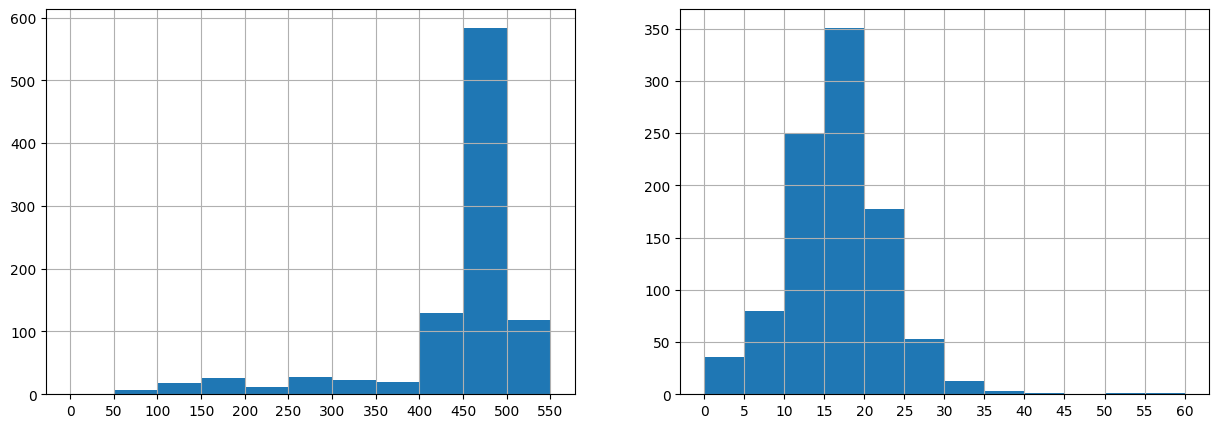

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


ax[0].set_xticks(np.arange(0, len(num_tokens), 50))
ax[0].grid()
ax[0].hist(num_tokens, bins=np.arange(0, np.max(num_tokens) + 50, 50))

ax[1].set_xticks(np.arange(0, len(num_sentences), 5))
ax[1].grid()
ax[1].hist(num_sentences, bins=np.arange(0, np.max(num_sentences) + 5, 5))


plt.savefig(f'{my_git_root}/notebooks/images/chunking_statistics/fixed_length_num_tokens.svg')
plt.show()

In [131]:
df_documents_chunked = pd.DataFrame(data={
    'name': names_chunked,
    'text': documents_chunked
})

In [132]:
df_documents_chunked.to_csv(f'{my_git_root}/data/documents_chunked_fixed_length.csv', index=False)